# <a id='toc1_'></a>Deep Learning: PhoBERT classification  [&#128522;](#toc0_)

**Nội dung, Table of contents**<a id='toc0_'></a>    
- [Deep Learning: PhoBERT classification ](#toc1_)    
    - [Lấy thông tin hệ điều hành, Getting operating system identification data ](#toc1_1_1_)    
    - [Kết nối Google Drive với Google Colab, Connecting Google Drive to Google Colab ](#toc1_1_2_)    
    - [Cài đặt các thư viện Python, Installing Python Libraries ](#toc1_1_3_)    
    - [Nhập các thư viện, Importing libraries ](#toc1_1_4_)    
    - [Thiết lập giá trị ngẫu nhiên cố định, Setting Random Seeds ](#toc1_1_5_)    
    - [Đặt thiết bị và tham số đào tạo, Setting the Device and Training Parameters ](#toc1_1_6_)    
    - [Lấy dữ liệu và thiết lập kiểm thử chéo K-Fold, Data Loading and K-Fold Cross-Validation Setup ](#toc1_1_7_)    
    - [Phân tích cân bằng các lớp bằng biểu đồ, Analyzing Class Imbalance with Charts ](#toc1_1_8_)    
    - [DataLoader ](#toc1_1_9_)    
    - [Model ](#toc1_1_10_)    
    - [Train & Eval Function ](#toc1_1_11_)    
    - [Training with K-Fold ](#toc1_1_12_)    
    - [ Model Testing & Results ](#toc1_1_13_)    
    - [Heatmap between Predict and Ground Truth ](#toc1_1_14_)    
    - [Visualize Wrong Predicted Label ](#toc1_1_15_)    
    - [Inference ](#toc1_1_16_)    
    - [Thanks for reading 🥰🥰🥰](#toc1_1_17_)    
    - [References: ](#toc1_1_18_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>Lấy thông tin hệ điều hành, Getting operating system identification data  [&#128522;](#toc0_)

In [1]:
!cat /etc/os-release

PRETTY_NAME="Ubuntu 22.04.2 LTS"
NAME="Ubuntu"
VERSION_ID="22.04"
VERSION="22.04.2 LTS (Jammy Jellyfish)"
VERSION_CODENAME=jammy
ID=ubuntu
ID_LIKE=debian
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
UBUNTU_CODENAME=jammy


### <a id='toc1_1_2_'></a>Kết nối Google Drive với Google Colab, Connecting Google Drive to Google Colab  [&#128522;](#toc0_)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!ln -s /content/gdrive/MyDrive /mydrive

### <a id='toc1_1_3_'></a>Cài đặt các thư viện Python, Installing Python Libraries  [&#128522;](#toc0_)

In [4]:
# For read excel format form pandas
%%bash
pip install openpyxl
pip install torch
pip install gensim
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 41.0 MB/s eta 0:00:00


### <a id='toc1_1_4_'></a>Nhập các thư viện, Importing libraries  [&#128522;](#toc0_)

In [5]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

### <a id='toc1_1_5_'></a>Thiết lập giá trị ngẫu nhiên cố định, Setting Random Seeds  [&#128522;](#toc0_)

In [6]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)

### <a id='toc1_1_6_'></a>Đặt thiết bị và tham số đào tạo, Setting the Device and Training Parameters  [&#128522;](#toc0_)

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 8
N_SPLITS = 10

### <a id='toc1_1_7_'></a>Lấy dữ liệu và thiết lập kiểm thử chéo K-Fold, Data Loading and K-Fold Cross-Validation Setup  [&#128522;](#toc0_)

In [8]:
# def get_data(path):
#     df = pd.read_excel(path, sheet_name=None)['Sheet1']
#     df.columns = ['index', 'Emotion', 'Sentence']
#     # unused column
#     df.drop(columns=['index'], inplace=True)
#     return df

# train_df = get_data('/space/UIT-VSMEC/train_nor_811.xlsx')
# valid_df = get_data('/space/UIT-VSMEC/valid_nor_811.xlsx')
# test_df = get_data('/space/UIT-VSMEC/test_nor_811.xlsx')

def get_data(path):
  return pd.read_csv(path)

train_df = get_data('/mydrive/data/train.csv')
test_df = get_data('/mydrive/data/test.csv')
# We will use Kfold later
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.label)):
    train_df.loc[val_, "kfold"] = fold

In [9]:
train_df.sample(10)

,comment,label,kfold
309,tóm lại m với o thì bác nào thích vọc vạch upr...,pos,7.0
239,e thì chưa thấy bị sao gửi từ google pixel 3 x...,pos,5.0
2,giá cao vl e mua con pixel 4 có 5 triệu 7 mà ổ...,neg,0.0
382,mùa dịch mấy anh ship giá mắc hơn bình thường ...,neg,9.0
12,loa thì chắc chắn hơn đứt mi 8. mic thì e ko b...,pos,0.0
3,lock thì mỗi lần reset máy xong phải cắm vào m...,pos,0.0
139,của mình không hiện giống bác nhưng hiện là số...,neg,3.0
1,"3xl dùng ngon, trước mình sài 1 tháng ưng dã m...",pos,0.0
133,em có con pixel 2 mà nó bị vọng lại tiếng của ...,neg,3.0
191,trước e thấy trên hội pixel có bác kia bán máy...,pos,4.0


In [10]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  405 non-null    object 
 1   label    405 non-null    object 
 2   kfold    405 non-null    float64
dtypes: float64(1), object(2)
memory usage: 9.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  102 non-null    object
 1   label    102 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


(None, None)

**=> No Missing Values**

### <a id='toc1_1_8_'></a>Phân tích cân bằng các lớp bằng biểu đồ, Analyzing Class Imbalance with Charts  [&#128522;](#toc0_)

<Axes: xlabel='label', ylabel='count'>

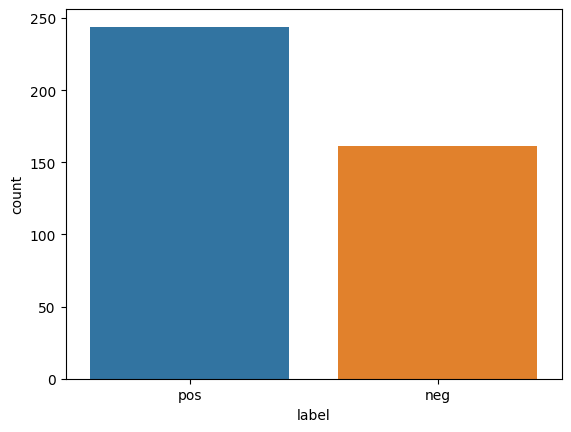

In [11]:
# sns.countplot(x='Emotion', data=train_df)
sns.countplot(x='label', data=train_df)

### <a id='toc1_1_9_'></a>DataLoader  [&#128522;](#toc0_)

In [12]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

In [13]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=120):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def labelencoder(self,text):
      return 0 if text == 'neg' else 1
        # if text=='Enjoyment':
        #     return 0
        # elif text=='Disgust':
        #     return 1
        # elif text=='Sadness':
        #     return 2
        # elif text=='Anger':
        #     return 3
        # elif text=='Surprise':
        #     return 4
        # elif text=='Fear':
        #     return 5
        # else:
        #     return 6

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        # text = row['Sentence']
        # text = ' '.join(simple_preprocess(text))
        # label = self.labelencoder(row['Emotion'])
        text = row['comment']
        label = self.labelencoder(row['label'])


        return text, label

**BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length.**

Text(0.5, 9.444444444444438, 'Token Count')

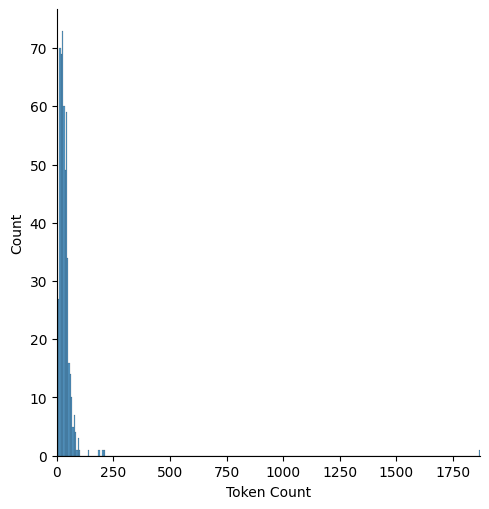

In [14]:
# Distribution of length of Sentence
all_data = train_df['comment'].tolist() + test_df['comment'].tolist()
# all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

**=> Choose a maximum of length of 100 is safe.**

### <a id='toc1_1_10_'></a>Model  [&#128522;](#toc0_)

In [15]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

### <a id='toc1_1_11_'></a>Train & Eval Function  [&#128522;](#toc0_)

In [16]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)

### <a id='toc1_1_12_'></a>Training with K-Fold  [&#128522;](#toc0_)

In [17]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = SentimentDataset(df_train, tokenizer, max_len=120)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=120)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)

    return train_loader, valid_loader

In [18]:
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    # model = SentimentClassifier(n_classes=7).to(device)
    model = SentimentClassifier(n_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = AdamW(model.parameters(), lr=2e-5)

    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=0,
                num_training_steps=len(train_loader)*EPOCHS
            )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'phobert_fold{fold+1}.pth')
            best_acc = val_acc

-----------Fold: 1 ------------------


Epoch 1/8
------------------------------
Train Accuracy: 0.6043956043956045 Loss: 0.6736610298571379
Valid Accuracy: 0.5609756097560976 Loss: 0.6807401776313782
Epoch 2/8
------------------------------
Train Accuracy: 0.6016483516483517 Loss: 0.646298216736835
Valid Accuracy: 0.6097560975609756 Loss: 0.6776244242986044
Epoch 3/8
------------------------------
Train Accuracy: 0.7225274725274726 Loss: 0.5857241529485454
Valid Accuracy: 0.6585365853658537 Loss: 0.6741282343864441
Epoch 4/8
------------------------------
Train Accuracy: 0.7747252747252747 Loss: 0.5068572824415953
Valid Accuracy: 0.5609756097560976 Loss: 0.7315433224042257
Epoch 5/8
------------------------------
Train Accuracy: 0.8351648351648352 Loss: 0.4303466872028682
Valid Accuracy: 0.6585365853658537 Loss: 0.7081983288129171
Epoch 6/8
------------------------------
Train Accuracy: 0.8901098901098902 Loss: 0.33867752033731213
Valid Accuracy: 0.6585365853658537 Loss: 0.8123013377189636
Epoch 7/8
------------------------

### <a id='toc1_1_13_'></a> Model Testing & Results  [&#128522;](#toc0_)

In [19]:
def test(data_loader):
    models = []
    for fold in range(skf.n_splits):
        # model = SentimentClassifier(n_classes=7)
        model = SentimentClassifier(n_classes=2)
        model.to(device)
        model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)

        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)

    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

In [20]:
test_dataset = SentimentDataset(test_df, tokenizer,  max_len=100)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)
real_values, predicts = test(test_loader)

              precision    recall  f1-score   support

           0       0.74      0.53      0.62        43
           1       0.72      0.86      0.78        59

    accuracy                           0.73       102
   macro avg       0.73      0.70      0.70       102
weighted avg       0.73      0.73      0.72       102



### <a id='toc1_1_14_'></a>Heatmap between Predict and Ground Truth  [&#128522;](#toc0_)

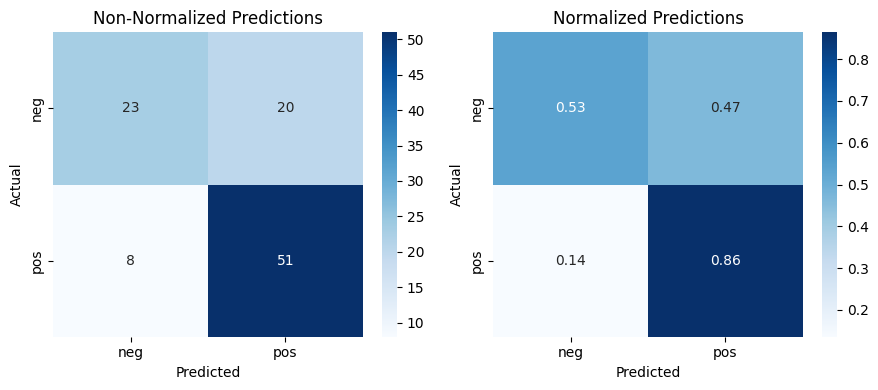

In [21]:
class_names = ['neg', 'pos']

# Create a confusion matrix
cm = confusion_matrix(real_values, predicts)

# Create a non-normalized confusion matrix plot
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Non-Normalized Predictions')

# Create a normalized confusion matrix plot
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.subplot(1, 2, 2)
sns.heatmap(normalized_cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Predictions')

plt.tight_layout()
plt.show()

### <a id='toc1_1_15_'></a>Visualize Wrong Predicted Label  [&#128522;](#toc0_)

In [22]:
def get_index_wrong(real_values, predicts):
    index_wrong = []
    for i in range(len(real_values)):
        if real_values[i] != predicts[i]:
            index_wrong.append(i)
    return index_wrong

index_list = get_index_wrong(real_values, predicts)
for i in range(10):
    print(test_df.iloc[index_list[i]].comment)
    print(f'Predicted: ({class_names[predicts[index_list[i]]]})'
    f'--vs-- Real label: ({class_names[real_values[index_list[i]]]})')
    print('-'*50)

pixel 4a lên giá 10.5 chai rồi
Predicted: (pos)--vs-- Real label: (neg)
--------------------------------------------------
chắc chắn là 1 cuộc cách mạng luôn. y như mấy con pixel đời đầu, đập chết tươi mấy con smartphone cùng thời về khoản chụp ảnh. hehe. nhưng sau đó thì các anh lại chấp nhận 3 năm tiếp theo không thay đổi phần cứng
Predicted: (neg)--vs-- Real label: (pos)
--------------------------------------------------
chắc thêm 2 300k nhưng với cái biên hiện tại chắc đổi trả mất tầm 2 tháng sent from u11 using vozfapp
Predicted: (pos)--vs-- Real label: (neg)
--------------------------------------------------
pixel 5 như kiểu muốn đấm liên tục vào mồm fan ý nhỉ. gửi từ xiaomi mi 8 se bằng vozfapp
Predicted: (pos)--vs-- Real label: (neg)
--------------------------------------------------
khác nhau ở việc cho phép unlock booloader eu có, us không. mua us cho rẻ vì thời đại này rảnh háng đâu mà đi nghịch rom, chưa kể là dùng pixel. máy nào cũng dùng được ít nhất 1 sim vật lý bình thư

### <a id='toc1_1_16_'></a>Inference  [&#128522;](#toc0_)

In [23]:
def infer(text, tokenizer, max_len=120):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Text: {text}')
    print(f'Sentiment: {class_names[y_pred]}')
    print('-'*50)

In [24]:
def clean_text(text: str):
    import re
    # URL removal and to lower case
    text = re.sub(r"https?://\S+|www\.\S+", "", text).lower()
    # emotion removal
    emotion_list = [":v", "=d", ":d", "<3", ":3"]
    for emotion in emotion_list:
        text = text.replace(emotion, "")
    # special characters removal
    pattern = r"[^0-9,.\saAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ]"
    text = re.sub(pattern, " ", text)
    # convert to standard words
    # 8 củ -> 8 triệu, 8tr2 -> 8.2 triệu, 8tr -> 8 triệu
    text = re.sub(r"(\d+)\s+củ", r"\1 triệu", text)
    text = re.sub(r"(\d+)tr(\d+)", r"\1.\2 triệu", text)
    text = re.sub(r"(\d+)tr", r"\1 triệu", text)
    # remove duplicate spaces
    text = re.sub(r"\s+", " ", text)
    return text.strip()

In [25]:
texts = [
    'Con 6 nhanh nóng máy lắm, nhất là trời nóng thế này. Bác cố lên con 7 ý.',
    'Tầm 6h được đó bác, 7- 7Pro giờ nó khá mát, pin cũng ổn + rom gốc rất mượt.',
    'Em thấy ai cũng chê mà em dùng cũng mát, công sở nhiều khi sáng hôm trước đến trưa hôm sau mới sạc. Em không lướt fb với tiktok :D, game thì nhẹ nhàng 20 30 phút.',
    'pixel 7 - 7 pro giờ ROM sau 1 năm tối ưu khá tốt rồi bác, gần như không có mấy cái lỗi nóng linh tinh hay loạn cảm ứng như hồi mới ra nữa. Google camera sau 1 năm cũng được update nhiều bản khá tốt rồi.\
    mình dùng 7 pro lock adb, dùng 3 tháng rồi thấy vậy.',
    'Same, lỗi quá nhiệt là lý do em bán con Pixel 6 Pro đi. Mặc dù em ko hề chơi game nhé',
    'con đó 8a nhìn cầm vừa vặn mà bạn. màn hình phẳng nữa chắc dễ cầm nắm',
    'Ngon - bổ - khá rẻ bác nhé, độ mượt thì max level ',
    'con này nó bo góc nhiều nhưng cái cam lại kẻ 2 vạch thẳng nên thấy lạc quẻ, làm cái cam vẫn ngang nhưng bo bên trong lại như pixel fold nhìn có thể đỡ thấy cái cam nó lạc lõng hơn',
    'con 5a cũng tử nhiều mà, nóng quá nên toi main, bọn 6 sang năm cứ coi chừng'
]
for text in texts:
  text = clean_text(text)
  infer(text, tokenizer)

Text: con 6 nhanh nóng máy lắm, nhất là trời nóng thế này. bác cố lên con 7 ý.
Sentiment: pos
--------------------------------------------------
Text: tầm 6h được đó bác, 7 7pro giờ nó khá mát, pin cũng ổn rom gốc rất mượt.
Sentiment: pos
--------------------------------------------------
Text: em thấy ai cũng chê mà em dùng cũng mát, công sở nhiều khi sáng hôm trước đến trưa hôm sau mới sạc. em không lướt fb với tiktok , game thì nhẹ nhàng 20 30 phút.
Sentiment: pos
--------------------------------------------------
Text: pixel 7 7 pro giờ rom sau 1 năm tối ưu khá tốt rồi bác, gần như không có mấy cái lỗi nóng linh tinh hay loạn cảm ứng như hồi mới ra nữa. google camera sau 1 năm cũng được update nhiều bản khá tốt rồi. mình dùng 7 pro lock adb, dùng 3 tháng rồi thấy vậy.
Sentiment: pos
--------------------------------------------------
Text: same, lỗi quá nhiệt là lý do em bán con pixel 6 pro đi. mặc dù em ko hề chơi game nhé
Sentiment: pos
--------------------------------------------

### <a id='toc1_1_17_'></a>Thanks for reading 🥰🥰🥰

### <a id='toc1_1_18_'></a>References:  [&#128522;](#toc0_)

* https://github.com/VinAIResearch/PhoBERT

* https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

* http://nlp.uit.edu.vn/datasets/

* https://www.kaggle.com/code/shoheiazuma/tweet-sentiment-roberta-pytorch/notebook#Model

* https://skimai.com/fine-tuning-bert-for-sentiment-analysis/